In [122]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import cmocean as cm
import glob
import os
import xarray as xr
import datetime
from salishsea_tools import viz_tools, tidetools, geo_tools, gsw_calls, wind_tools
import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sys import platform

%matplotlib inline

In [2]:
## User inputs.  As set up now, darwin -> paths on Rachael's "shuga" laptop 
## The other paths are for Vicky's Ocean setup

if platform == 'darwin':
    bathy_dir = '/Users/rmueller/Data/SalishSeaCast/grid/'
    results_dir = '/Users/rmueller/Projects/'
    out_dir = '/Users/rmueller/Documents/Presentations/2020/OceanSciences2020/'
else:
    display('Update file paths for oceans machine')
    
# Set to [1] if you want to print to file and [0] if not
print_to_file = 0  

In [3]:
## colourmap for the land/water. 
vmax = 1
cmap2 = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, 'lightskyblue'), #change this if you want a different colour for water
                                                    (0.85 / vmax, 'lightskyblue'), #change this if you want a different colour for water
                                                    (0.850001 / vmax, 'papayawhip'), #change this if you want a different colour for land
                                                    (1 / vmax, 'papayawhip')] #change this if you want a different colour for land
                                        )

### Compare 2D concentrations for early beaching case of 01 Aug, 2017, with more delayed beaching case of 15 Jan, 2018

In [92]:
# create labels for plotting and for file names
date_labels = ['Aug 01, 2017', 'Jan 15, 2018'] # for plotting
date_ranges = ['01aug17-08aug17', '15jan18-22jan18'] # for file naming 
oil_types = ['bunker','akns','diesel']

In [89]:
# create variables bunker_0_thick, bunker_1_thick, etc. where numeric vals. reflect date
ndates = len(date_ranges)
for oils in oil_types:
    # set index for dates corresponding to date_labels
    
    # define input paths for different oil types
    if oils == 'bunker':
        for ii in range(ndates):
            locals()["inpath_" + str(ii)] = ["MIDOSS/results/OS2020/bunkerc/SB/Lagrangian_BunkerC_crude_SB_" + date_ranges[ii] + "_BunkerC.nc"]
    elif oils == 'akns':
        for ii in range(ndates):
            locals()["inpath_" + str(ii)] = ["MIDOSS/results/OS2020/akns/SB/Lagrangian_AKNS_crude_" + date_ranges[ii] + "_Diesel.nc"]
    elif oils == 'diesel':
        for ii in range(ndates):
            locals()["inpath_" + str(ii)] = ["MIDOSS/results/OS2020/diesel/SB/Lagrangian_DieselFuel_refined_SB_" + date_ranges[ii] + "_Diesel.nc"]
    
    for ii in range(ndates):
        print(locals()['calculating integrated thickness for ' oils + date_ranges(ii)])
        locals()[oils + "_" + str(ii)] = xr.open_dataset(results_dir + locals()['inpath_' + str(ii)][0])
        locals()[oils + "_" + str(ii) + "_thick"] = locals()[oils + "_" + str(ii)].Thickness_2D
        locals()[oils + "_" + str(ii) + "_thick_t"] = locals()[oils + "_" + str(ii) + "_thick"].sum(dim='time')
        

### plot up 2D thickness

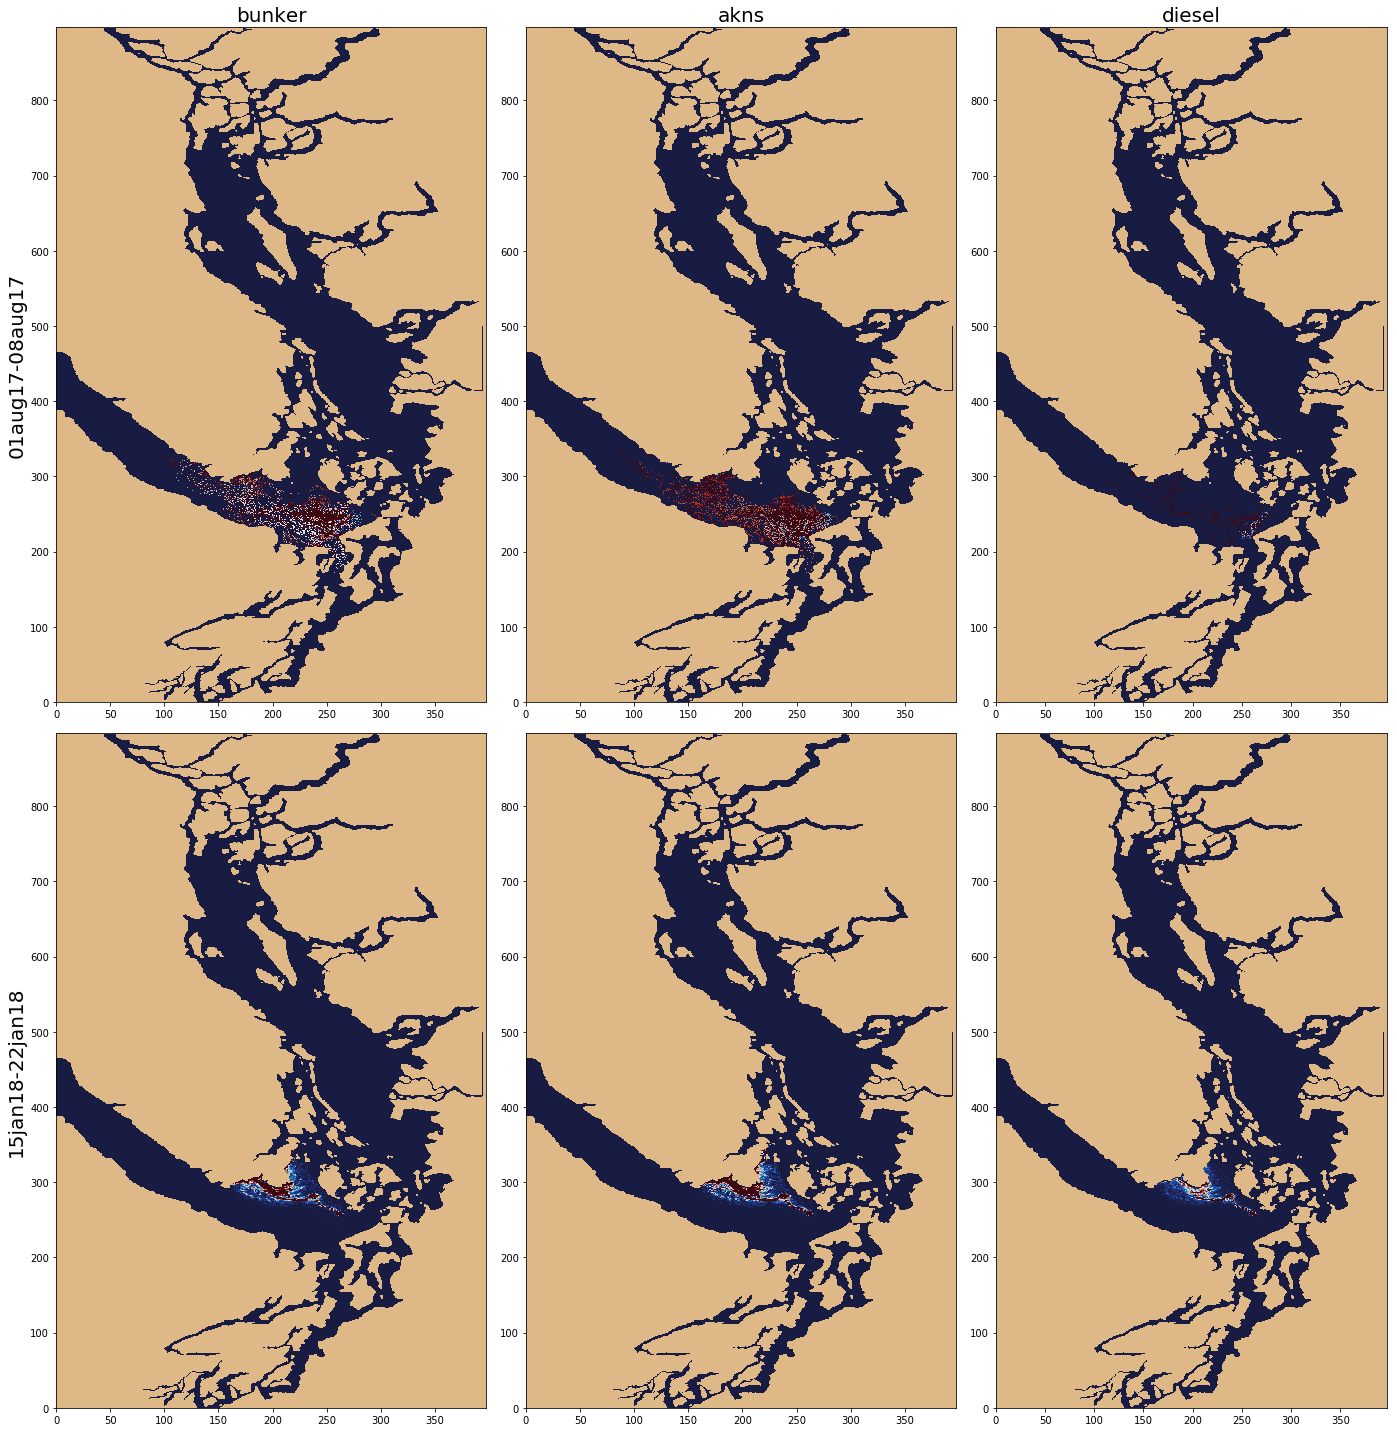

In [124]:
fs = 20
fig = plt.figure(figsize=(20,20))
# plot oil types
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
# convert xarray into numpy using ".values" in order to gain access to different visualization tools
mappable = ax1.pcolormesh(akns_0_thick_t.values, vmin = 0, vmax = 40, cmap = cm.cm.balance)
mappable = ax2.pcolormesh(bunker_0_thick_t.values, vmin = 0, vmax = 40, cmap = cm.cm.balance)
mappable = ax3.pcolormesh(diesel_0_thick_t.values, vmin = 0, vmax = 40, cmap = cm.cm.balance)

mappable = ax4.pcolormesh(akns_1_thick_t.values, vmin = 0, vmax = 40, cmap = cm.cm.balance)
mappable = ax5.pcolormesh(bunker_1_thick_t.values, vmin = 0, vmax = 40, cmap = cm.cm.balance)
mappable = ax6.pcolormesh(diesel_1_thick_t.values, vmin = 0, vmax = 40, cmap = cm.cm.balance)

# add land mask to ax1 and ax2
for ii in range(6):
    axis = locals()['ax' + str(ii+1)]
    viz_tools.plot_land_mask(axis,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')

    # adjust colorbar for AKNS graphic
divider = make_axes_locatable(ax6)
c1 = divider.append_axes("right", size = '10%')
cb = plt.colorbar(mappable, cax = c1)
cb.set_label('Thickness (microns) summed over full run', fontsize=fs)
cb.ax.tick_params(labelsize = fs)
cb.remove()

divider = make_axes_locatable(ax3)
c1 = divider.append_axes("right", size = '10%')
cb = plt.colorbar(mappable, cax = c1)
cb.set_label('Thickness (microns) summed over full run', fontsize=fs)
cb.ax.tick_params(labelsize = fs)
cb.remove()

ax1.set_title(oil_types[0], fontsize = fs)
ax1.set_ylabel(date_ranges[0], fontsize = fs)
ax2.set_title(oil_types[1], fontsize = fs)
ax3.set_title(oil_types[2], fontsize = fs)
ax4.set_ylabel(date_ranges[1], fontsize = fs)

plt.tight_layout()
fig.savefig(results_dir + 'SB_2date_oiltype_comparison.png', bbox_inches='tight', dpi = 600);

### plot up spill area comparison

In [18]:
#### Load header information

with open('/Users/rmueller/Projects/MIDOSS/results/OS2020/bunkerc/SB/resOilOutput_01aug2017.sro', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
    header = all_data[4]  
    
# Order header into list array by splitting up string
header_arr = []
header_arr = header.split(' ')
# Remove emtpy entries from list
header_arr = np.asarray([x for x in header_arr if x != ''])
header_arr

array(['Seconds', 'YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'MassOil',
       'VolOilBeached', 'VolumeBeached', 'VolumeOil', 'Volume', 'Area',
       'TeoricalArea', 'Thickness', 'MEvaporated', 'VEvaporated',
       'FMEvaporated', 'MDispersed', 'VDispersed', 'FMDispersed',
       'MSedimented', 'VSedimented', 'FMSedimented', 'MDissolved',
       'VDissolved', 'FMDissolved', 'MChemDisp', 'VChemDisp', 'FMChemDisp',
       'MOilRecovered', 'VOilRecovered', 'FMOilRecovered', 'MWaterContent',
       'VWaterContent', 'Density', 'Viscosity', 'MBio', 'VBio', 'FMBio',
       'CharacteristicDiameter', 'P_Star', 'AnalyteMass1', 'AnalyteMass2',
       'AnalyteMass3', 'AnalyteMass4', 'AnalyteMass5', 'AnalyteBio1',
       'AnalyteBio2', 'AnalyteBio3', 'AnalyteBio4', 'AnalyteBio5'],
      dtype='<U22')

In [19]:
# load mass balance area values
aug01_17_sro_in = '/Users/rmueller/Projects/MIDOSS/results/OS2020/bunkerc/SB/resOilOutput_01aug2017.sro'
jan15_18_sro_in = '/Users/rmueller/Projects/MIDOSS/results/OS2020/bunkerc/SB/resOilOutput_15jan2018.sro'
data_aug01_17 = np.genfromtxt(aug01_17_sro_in, skip_header=6, skip_footer=4)
data_jan15_18 = np.genfromtxt(jan15_18_sro_in, skip_header=6, skip_footer=4)
data_aug01_17.shape

(191, 52)

In [20]:
data_jan15_18.shape

(129, 52)

Text(0.5,1,'Dispersed Mass Balance Comparison')

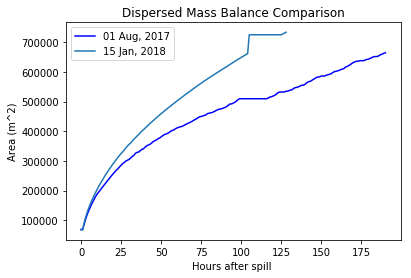

In [29]:
plot_data = 12
plt.plot(data_aug01_17[range(191),12],'b')
plt.plot(data_jan15_18[range(129),12])
plt.ylabel('Area (m^2)')
plt.xlabel('Hours after spill ')
plt.legend(['01 Aug, 2017', '15 Jan, 2018'])
plt.title('Dispersed Mass Balance Comparison')